## 7-1 인공 신경망

In [ ]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다.
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

## 패션 MNIST

In [ ]:
from tensorflow import keras

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
print(train_input.shape, train_target.shape)

(60000, 28, 28) (60000,)


In [ ]:
print(test_input.shape, test_target.shape)

(10000, 28, 28) (10000,)


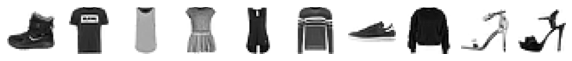

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 10, figsize = (10, 10))

for i in range(10):
  axs[i].imshow(train_input[i], cmap = 'gray_r')
  axs[i].axis('off')
plt.show()

In [ ]:
print([train_target[i] for i in range(10)]) # 0~9까지의 의류 데이터

[9, 0, 0, 3, 0, 2, 7, 2, 5, 5]


In [ ]:
import numpy as np

print(np.unique(train_target, return_counts = True))
# 0~9까지의 의류 데이터 각각 6천개씩 총 6만개의 의류 데이터

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))


## 로지스틱 회귀로 패션 아이템 분류하기

In [ ]:
# 이미지 데이터는 표준화를 하지 않고 그냥 255로 나누어 0~1 사이의 값을 가지도록 만들어도 결과가 잘 나온다.
train_scaled = train_input / 255
train_scaled = train_scaled.reshape(-1, 28 * 28) # (28x28)의 2차원 의류 데이터를 1차원으로 축소

In [ ]:
print(train_scaled.shape)

(60000, 784)


In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDClassifier

# 경사하강법을 적용한 로지스틱 회귀
sc = SGDClassifier(loss = 'log', max_iter = 5, random_state = 42)
# 사이킷런은 손실함수를 log로 지정하면 이진 분류일때는 로지스틱 손실함수를 사용해서 모델을 훈련하고
# 다중 분류일때는 10번의 이진 분류를 시행한다. 이렇게 나온 10개의 z값을 소프트맥스 함수로 계산한다.

scores = cross_validate(sc, train_scaled, train_target, n_jobs = -1)

In [ ]:
print(np.mean(scores['test_score'])) # 약 82%의 정확도

0.8195666666666668


## 인공신경망

### 텐서플로와 케라스

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow import keras

## 인공신경망으로 모델 만들기

In [ ]:
# cross-validation을 한다면 굳이 검증세트가 필요 없지만 딥러닝에서는 교차검증을 잘 하지 않는다. 따라서 validation set을 생성
# 데이터가 많기 때문에 검증 점수가 높으면서 안정되어 있고 데이터가 많기 때문에 계산 비용이 많이 들어 k-fold cross-validation을 하지 않음
from sklearn.model_selection import train_test_split

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size = 0.2, random_state = 42
)

In [ ]:
print(train_scaled.shape, train_target.shape)

(48000, 784) (48000,)


In [ ]:
print(val_scaled.shape, val_target.shape)

(12000, 784) (12000,)


In [ ]:
# 출력층 객체 생성 (출력층의 수는 항상 클래스의 수와 같아야 함)
dense = keras.layers.Dense(10, activation = 'softmax', input_shape = (784,)) # 10개의 출력층 지정
# 다중분류이기 때문에 활성화 함수로 softmax 함수를 지정 (이진분류라면 sigmoid)
# input_shape는 28*28의 1차원 튜플로 전달

In [ ]:
model = keras.Sequential(dense) # keras 모델에 dense 출력층을 집어 넣음 (Sequential: keras의 모델을 만드는 함수)
# model: keras의 인공신경망 모델

## 인공신경망으로 패션 아이템 분류하기

In [ ]:
# 모델을 훈련하기 전에 손실함수를 정하는 작업을 우선적으로 해야함
model.compile(loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
# sparse는 타겟값이 원-핫 인코딩 형태가 아니라 그냥 정수형일때 사용하고 싶으면 붙혀주는 옵션
# 만약 타겟값이 원-핫 인코딩 형태라면 그냥 'categorical_crossentropy'라고 지정
# metrics = 'accuracy': 정확도를 기록하고 싶을 때

# 머신러닝에서 이진분류일때는 로지스틱 손실함수를 사용, 다중분류일때는 크로스 엔트로피함수를 사용
# keras에서는 이진분류일때는 바이너리 크로스 엔트로피함수, 다중분류일때는 카테고리컬 크로스 엔트로피함수 사용

In [ ]:
print(train_target[:10]) # 타겟값이 원-핫 인코딩 형태가 아닌 정수형이다.

[7 3 5 8 6 9 3 3 9 9]


In [ ]:
model.fit(train_scaled, train_target, epochs = 5)
# 에포크가 증가할 수록 loss값은 떨어지고 정확도는 증가한다. (알고리즘이 예측을 잘 할 수록 손실값은 떨어지기 때문)

Epoch 1/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6058 - accuracy: 0.7932
Epoch 2/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4785 - accuracy: 0.8385
Epoch 3/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4564 - accuracy: 0.8471
Epoch 4/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4435 - accuracy: 0.8539
Epoch 5/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4358 - accuracy: 0.8551


In [ ]:
# 훈련이 끝났으므로 생성해둔 validation set으로 평가를 해볼 수 있음
model.evaluate(val_scaled, val_target) # 약 85%의 검증 정확도를 보여줌

# keras는 모델을 만들고 훈련하고 설정하는 것들이 sklearn과는 다소 다르다.

375/375 [==============================] - 1s 3ms/step - loss: 0.4579 - accuracy: 0.8483


[0.45794257521629333, 0.8483333587646484]

## 7-2 심층 신경망

In [ ]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다.
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

## 2개의 층

In [ ]:
from tensorflow import keras

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
from sklearn.model_selection import train_test_split

train_scaled = train_input / 255.0
train_scaled = train_scaled.reshape(-1, 28*28)

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

In [ ]:
dense1 = keras.layers.Dense(100, activation='sigmoid', input_shape=(784,)) # 은닉층
dense2 = keras.layers.Dense(10, activation='softmax') # 출력층 (다중: softmax, 이진: sigmoid)
# 참고로 입력층은 층으로 취급하지 않음
# 출력층이 10개의 뉴런으로 이루어졌기 때문에 은닉층은 적어도 10개 보단 많아야 한다.
# 출력층보다 적은 뉴런을 은닉층에 두면 정보가 많이 손실 된다.

# 은닉층에도 활성화 함수를 사용하는 이유는 은닉층에 활성화 함수가 없으면
# 은닉층의 수식과 출력층의 수식을 합쳐 하나의 수식으로 표현이 가능하기 때문에 2개의 층이 필요 없어진다.
# 따라서 은닉층을 둔다는 것은 반드시 활성화 함수를 거쳐서 비선형 함수로 데이터를 변형해서 만든다.

## 심층 신경망 만들기

In [ ]:
model = keras.Sequential([dense1, dense2])

In [ ]:
model.summary()
# 은닉층은 100개의 뉴런이므로 100개의 출력이 만들어지고
# 출력층은 10개의 뉴련이므로 10개의 출력이 만들어진다.

# 은닉층의 파라미터 개수: 784*100 + 100 = 78500 (+ 100은 각 뉴런의 절편)
# 출력층의 파라미터 개수: 100*10 + 10 = 1010 (+ 10은 각 뉴런의 절편)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


## 층을 추가하는 다른 방법

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(100, activation='sigmoid', input_shape=(784,), name='hidden'),
    keras.layers.Dense(10, activation='softmax', name='output')
], name='패션 MNIST 모델')
# dense를 일일이 Sequential에 전달하지 않고 Sequential 매서드 자체에 dense층을 생성
# 단점: 하나하나 모두 입력하기 빡셈

In [ ]:
model.summary()

Model: "패션 MNIST 모델"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (Dense)              (None, 100)               78500     
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = keras.Sequential()
model.add(keras.layers.Dense(100, activation='sigmoid', input_shape=(784,)))
model.add(keras.layers.Dense(10, activation='softmax'))
# add 매서드를 통해 층을 추가해나가는 방식

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               78500     
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

model.fit(train_scaled, train_target, epochs=5)

Epoch 1/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.5628 - accuracy: 0.8073
Epoch 2/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4075 - accuracy: 0.8522
Epoch 3/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3741 - accuracy: 0.8652
Epoch 4/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.3509 - accuracy: 0.8732
Epoch 5/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3335 - accuracy: 0.8784


## 렐루 활성화 함수

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(28, 28)))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))
# Flatten층은 편의를 위해 만드는 층 (학습되는 파라미터(가중치)가 없음)
# 실제로 의미있는 작업을 하지 않으며 28*28의 2차원 이미지를
# 1차원 784 배열로 펼치는 작업을 대신 해 줌 (따라서 출력크기가 784)

# 필요한 전처리 과정을 따로 별도의 파이썬 코드로 작성하지 않고
# 가능하면 모델 안에 포함시키는 것이 유지 보수의 측면에서 좋다.

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               78500     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [ ]:
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

train_scaled = train_input / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

model.fit(train_scaled, train_target, epochs=5)

Epoch 1/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.5336 - accuracy: 0.8090
Epoch 2/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3934 - accuracy: 0.8579
Epoch 3/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3554 - accuracy: 0.8717
Epoch 4/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.3337 - accuracy: 0.8799
Epoch 5/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3181 - accuracy: 0.8859


In [ ]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3726 - accuracy: 0.8716


[0.37255606055259705, 0.8715833425521851]

## 옵티마이저

In [ ]:
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics='accuracy')
# optimizer = 'sgd': 확률적 경사 하강법 (기본적으로 32개씩 미니배치)

# 최적화 optimizer는 여러개 있으며 가장 기본적인게 sgd이다.

In [ ]:
sgd = keras.optimizers.SGD()
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics='accuracy')
# SGD 옵티마이저 객체를 만든 다음 optimizer 매개변수에 전달

In [ ]:
sgd = keras.optimizers.SGD(learning_rate=0.1)

In [ ]:
sgd = keras.optimizers.SGD(momentum=0.9, nesterov=True)
# sgd에서 조금 더 발전 된 것이 모멘텀, 모멘텀에서 좀 더 발전 된 것이 네스테로프 모멘텀
# 모멘텀과 RMSprop에 영향을 받은 것이 Adam

In [ ]:
adagrad = keras.optimizers.Adagrad()
model.compile(optimizer=adagrad, loss='sparse_categorical_crossentropy', metrics='accuracy')
# 적응적 학습률 옵티마이저: RMSprop, Adam, Adagrad
# 적응적 학습률 옵티마이저는 학습 초반에 경사를 빨리 내려가고 학습 후반에는
# 경사를 천천히 내려가는 등의 조절을 함 (학습률이 모델을 점차 학습함에 따라 변화)

In [ ]:
rmsprop = keras.optimizers.RMSprop()
model.compile(optimizer=rmsprop, loss='sparse_categorical_crossentropy', metrics='accuracy')

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(28, 28)))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

model.fit(train_scaled, train_target, epochs=5)
# Adam 옵티마이저를 사용한 예이며 참고 정도만 하기

Epoch 1/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.5240 - accuracy: 0.8167
Epoch 2/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3917 - accuracy: 0.8601
Epoch 3/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3537 - accuracy: 0.8721
Epoch 4/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3284 - accuracy: 0.8801
Epoch 5/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3075 - accuracy: 0.8865


In [ ]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3626 - accuracy: 0.8699


[0.36262255907058716, 0.8699166774749756]

## 7-3 신경망 모델 훈련

In [ ]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다.
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

## 손실 곡선

In [ ]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()

train_scaled = train_input / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

In [ ]:
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(100, activation='relu'))
    if a_layer:
        model.add(a_layer)
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [ ]:
model = model_fn()

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               78500     
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=5, verbose=0)

In [ ]:
print(history.history.keys()) # 손실값과 정확도값이 들어있음

dict_keys(['loss', 'accuracy'])


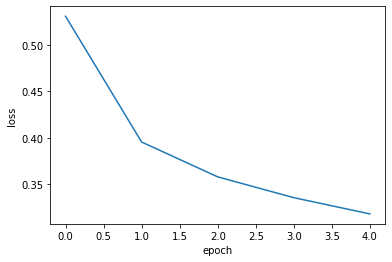

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

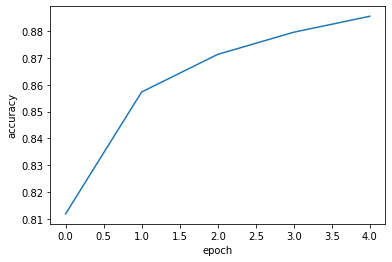

In [ ]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()
# 에포크를 늘리면 loss가 줄며 점점 모델이 복잡해지고 훈련세트에 점점 잘 맞는 모델이 만들어진다.
# 하지만 실전에 투입했을때 새로운 데이터인 test 데이터에 잘 일반화 되지 않는 단점이 있다.
# 따라서 너무 훈련세트에 잘 맞는 모델을 만드는 것이 아니라 검증 세트나 테스트 세트에서
# 적절한 일반화 성능을 얻을 수 있는 절충점(trade off)을 찾아야 한다.

In [ ]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0)

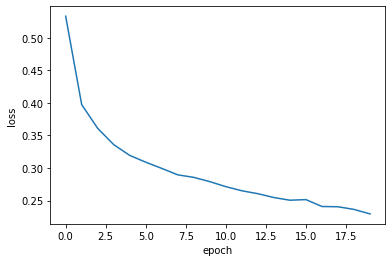

In [ ]:
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 검증 손실

In [ ]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


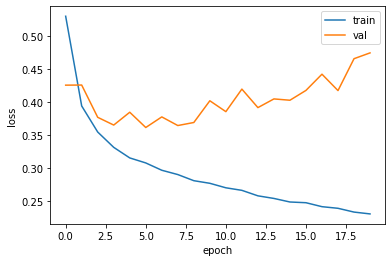

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()
# train 데이터는 당연히 에포크가 증가할수록 손실값이 줄어듦 (그런식으로 훈련을 하기 때문)
# 하지만 test는 값이 오르락내리락 함 (에포크가 증가할수록 train에 과대적합 되기 때문)

# 과대적합을 해결할 수 있는 방법으로 이전에 L1, L2 규제 등을 배웠다.
# 하지만 신경망에서는 신경망에만 있는 규제 방법을 많이 사용한다. (드롭아웃)

In [ ]:
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))

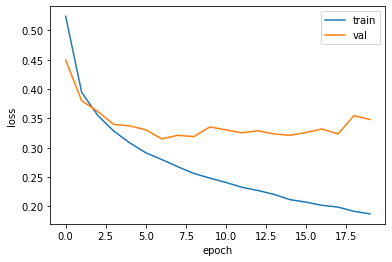

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()
# Adam 옵티마이저를 사용해도 결과는 비슷함

## 드롭아웃

In [ ]:
# 은닉층에 있는 뉴런 몇개를 임의로 계산하지 않는다. (마치 없는 것 처럼 훈련때 삭제)
# 이런식으로 랜덤하게 여러번 몇개의 뉴런을 선택해서 계산하지 않는 과정을 반복한다.
# 뉴런 중에 몇퍼센트를 계산하지 않을지는 매개변수로 지정해줘야 한다. (하이퍼파라미터)
# 이렇게 뉴런 계산을 몇개 빼면 훈련세트에 잘 맞지 않게 된다. (과대적합 해소)
# 또한 어떤 뉴런에 과도하게 예측을 의존하는 경향도 해소할 수 있다.

# 이렇게 훈련 후에 테스트나 평가를 할 때는 모든 뉴런을 사용

model = model_fn(keras.layers.Dropout(0.3)) # 드롭아웃층 (은닉층 중 30%가 랜덤하게 계산되지 않게 만듦)

model.summary()
# 드롭아웃층이 summary 매서드에 추가된 것을 확인 가능 (은닉층의 크기와 동일)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_10 (Dense)            (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))

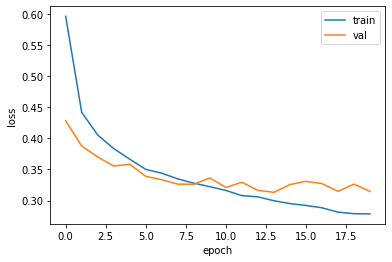

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 모델 저장과 복원

In [ ]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=10, verbose=0,
                    validation_data=(val_scaled, val_target))

In [ ]:
model.save_weights('model-weights.h5') # 파라미터(가중치, 절편)만 저장 (모델의 구조 저장 X)

In [ ]:
model.save('model-whole.h5') # 모델 구조와 파라미터(가중치, 절편)를 모두 저장

In [ ]:
!ls -al *.h5

-rw-r--r-- 1 root root 333448 Dec 18 09:44 model-weights.h5
-rw-r--r-- 1 root root 982664 Dec 18 09:44 model-whole.h5


In [ ]:
model = model_fn(keras.layers.Dropout(0.3))

model.load_weights('model-weights.h5')

In [ ]:
import numpy as np

val_labels = np.argmax(model.predict(val_scaled), axis=-1) # -1로 지정하면 마지막 인덱스가 됨
# 데이터가 2차원 배열이기 때문에 axis는 0 또는 1이 가능하므로 -1은 1의 의미와 같음
print(np.mean(val_labels == val_target))

375/375 [==============================] - 1s 2ms/step
0.8843333333333333


In [ ]:
model = keras.models.load_model('model-whole.h5')

model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3304 - accuracy: 0.8843


[0.33038875460624695, 0.8843333125114441]

## 콜백

In [ ]:
# 모델을 훈련하는 도중에 지정한 작업을 수행해주는 것

model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5',
                                                save_best_only=True)

model.fit(train_scaled, train_target, epochs=20, verbose=0,
          validation_data=(val_scaled, val_target),
          callbacks=[checkpoint_cb])
# fit 매서드를 통해서 훈련하는 도중에 검증 데이터의 가장 낮은 손실값이 되는 모델을 저장

In [ ]:
model = keras.models.load_model('best-model.h5')

model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3185 - accuracy: 0.8855


[0.3184833824634552, 0.8855000138282776]

## 조기종료

In [ ]:
# 검증세트의  손실이 증가하는 지점부터는 굳이 훈련을 계속 진행할 필요가 없기 때문에 조기종료가 필요

model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5',
                                                save_best_only=True) # 일단은 선언
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)
# patience 옵션은 검증 세트의 점수가 증가하다가 감소할 수도 있는데 그 증가할 때를
# 몇 번 에포크까지 참을 것인지를 지정해주는 옵션 (따라서 2번 연속 증가까지 참는다는 뜻)

# 여기서 반드시 1번째 연속보다 2번째 연속이 더 클 필요는 없고 기존의 지점에서
# 각각 1번째와 2번째 연속이 모두 증가했으면 증가한걸로 본다.

# restore_best_weight = True는 가장 손실이 낮았던 가중치로 되돌리라는 뜻

history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

In [ ]:
print(early_stopping_cb.stopped_epoch) # 9번 에포크에서 멈춤 (index가 0부터 시작이기 때문)
# 따라서 patience = 2로 두었기 때문에 7번 에포크가 가장 좋다고 할 수 있다.

8


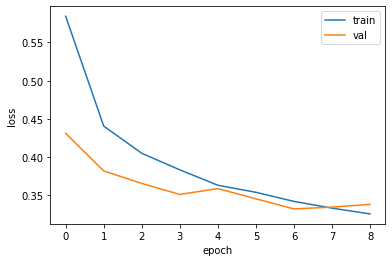

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.3294 - accuracy: 0.8803


[0.3294179141521454, 0.8803333044052124]